# Tutorial for HyperTraPS

This is a tutorial demonstrating the HyperTraPS inference pipeline. We use one of the standard synthetic datasets included in the "datasets/" folder but you could substitute any dataset (that meets the requirements outlined in "README.md") into the appropriate directory and adjust accordingly to run the inference.


## Initial imports (assumes "configure.sh" has been run and all python dependencies installed)

In [1]:
import pandas as pd
import numpy as np
import os
import subprocess
import matplotlib.pyplot as plt

## Set-up an example workspace directory in which to use HyperTraPS

In [2]:
%%capture
prefix = "../example_workspace"
os.makedirs(prefix, exist_ok=True)
%cd {prefix}

## Choose dataset from datasets folder
We choose a simple "test-data-2-7.csv" that is a set of evenly spaced cross-sectional samples from two underlying forwards and backwards paths with L=7.

In [3]:
dataset = "../datasets/synthetic/test-data-2-7.csv"
input_type = "cross-sectional"

We can load and visualise the dataset. The rows are samples and the columns are features. Each element is binary to denote presence or absence.

In [4]:
raw_data = pd.read_csv(dataset, index_col=0)
print(f"Dataset has {raw_data.shape[0]} samples and {raw_data.shape[1]} features.")
raw_data.head()

Dataset has 16 samples and 7 features.


,1,2,3,4,5,6,7
1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0
5,1,1,0,0,0,0,0
7,1,1,1,0,0,0,0
9,1,1,1,1,0,0,0


## Perform conversion of dataset into transition dataset
This converts the standard csv dataframe into one that can be passed to HyperTraPS.

In [5]:
%%capture
!python ../src/python/convert_data_to_transitions.py -data {dataset} -input_type {input_type}

## Run the MCMC sampler with desired parameterisation
The cell below shows help message, subsequent cell runs on data.

In [6]:
mcmc_exe = "../bin/RUN_MCMC_SAMPLER"
!{mcmc_exe} -h


----------------------------------------------------------------------------------------------------

HyperTraPS Discrete Time - MCMC Sampler

----------------------------------------------------------------------------------------------------

Usage options:
  -f <input data file = "transitions.txt">
  -M <model type = "second-order">
     Can take: "first-order" or "second-order"
  -N <number of posterior samples  = 500>
  -r <HyperTraPS trajectories per transition = 200>
  -n <MCMC start matrix = "zero">
     Can take: "zero"
               "uniform"
  -p <prior range in log space = 20, (-20,20)>
  -k <proposal kernel = "mcmc">
     Can take: "mcmc" or "mcmc-apm" for auxiliary pseudo marginal mcmc
  -s <sigma for gaussian proposal kernel = 0.025>
  -b <burn in = 50000>
  -i <iid steps between posterior sample draws = 100>
  -S <seed = 0>
  -t <threads or processors = hardware - 1>
  -q <auxiliary pseudo marginal proposal type = 0>
     Switches between proposing all new random walk

In [7]:
%%capture
transitions = "transitions.txt"
model_type = "second-order"
trajectories = 20
posterior_samples = 1000
start_matrix = "zero"
prior_range = 20
proposal_kernel = "mcmc-apm"
sigma_for_kernel = 0.025
burn_in = 50000
iid_steps = 100
seed = 0
threads = 3
apm_proposal_kernel = 0
verbosity = 1

!{mcmc_exe}\
    -f {transitions}\
    -M {model_type}\
    -N {posterior_samples}\
    -r {trajectories}\
    -n {start_matrix}\
    -p {prior_range}\
    -k {proposal_kernel}\
    -s {sigma_for_kernel}\
    -b {burn_in}\
    -i {iid_steps}\
    -S {seed}\
    -t {threads}\
    -q {apm_proposal_kernel}

## Plot the trace of the MCMC chain and examine if burn-in is satisfied by inspection

In [8]:
%%capture
!python ../src/python/plot_mc_stats.py

In [9]:
# Mini-function for this tutorial to show the output pngs
def ShowImage(filename):
    import matplotlib.image as mpimg
    plt.figure(figsize = (15,8))
    img = mpimg.imread(filename)
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()

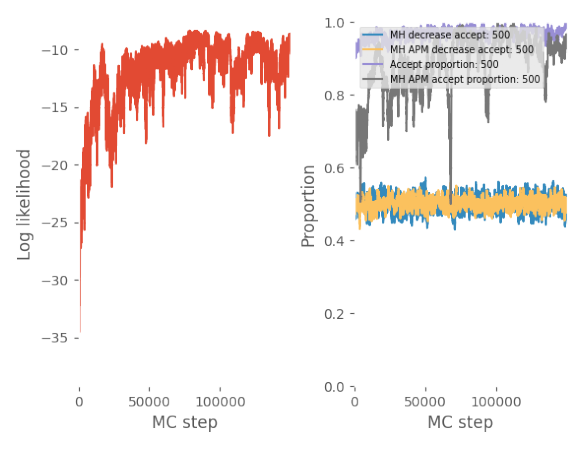

In [10]:
ShowImage("stats-0.png")

## Run random walk samplers WS1 and WS2 to generate sample trajectories from the posterior samples
The chain looks approximately stationary from 50,000 onwards. We'll use samples from beyond this region.

In [11]:
pw_exe = "../bin/RUN_PW"
!{pw_exe} -h


----------------------------------------------------------------------------------------------------

HyperTraPS Discrete Time - Random Walk Sampling

----------------------------------------------------------------------------------------------------

Usage options:
  -f <input data file = "transitions.txt">
  -L <model type = "forwards.txt">
  -w <walk simulation type  = "zero-one" =: "WS1">
     Can take: "zero-one" =: "WS1" or "match-data" =: "WS2"
  -b <burn in from MCMC sampler (assumed posterior sampling after) = 50000>
  -e <limit of posterior samples = -1 (unlimited by default)>
  -i <iid steps between posterior sample draws  = 100>
  -g <desired sample steps between sample draws = 100>
  -R <Number of times dataset is sampled for random walks = 10>
  -R <Generate resamples of dataset based on target counts = "no">
  -S <seed = 0>
  -v <verbosity = 0>
  -h or -? <print this message>
----------------------------------------------------------------------------------------------

In [12]:
%%capture
walk_types = ["zero-one", "match-data"]
burn_in = 50000
dataset_repeats = 100
for walk_type in walk_types:
    !{pw_exe}\
         -w {walk_type}\
         -b {burn_in}\
         -R {dataset_repeats}

## Make and view Transition Graphs


In [13]:
%%capture
pyscript = "../src/python/plot_hypercube_graph.py"
!{pyscript}\
    -f "forwards_list-pord-zero-one.csv"\
    -extra_labels_routes "20,2"\
    -label_type "greedy_data"\
    -labels_fontsize 4\
    -layout_type "spring"\
    -transition_data "transitions.txt"\
    -labels "labels.csv"\
    -aspect 0.9\
    -width 3.4\
    -gamma 0\
    -xlabel ""\
    -extra "no"\
    -xevery 1\
    -outfile_graph "forwards-hypercube-graph-zero-one-g0"\
    -out_type 'png'

__Inferred dynamics on the hypercubic transition graph.__ Edge widths and node areas are proportional to the number of times edges or nodes are encountered. States are plotted from left to right in order of the number of features acquired. Two competing pathways are clearly observable with feature acquisitions labelled at each step.

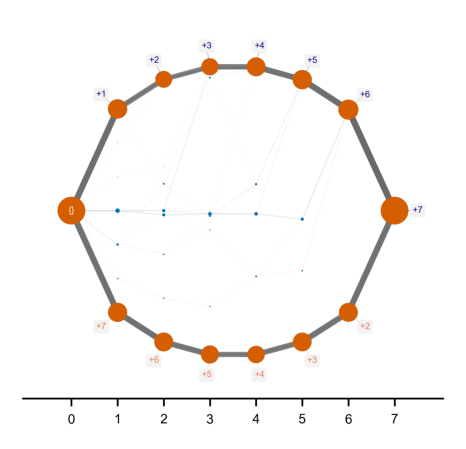

In [14]:
ShowImage("forwards-hypercube-graph-zero-one-g0.png")

## Make and view Feature Graphs

In [15]:
%%capture
pyscript="../src/python/plot_feature_graph.py"
!{pyscript}\
    -f "forwards.txt"\
    -prob_type "joint"\
    -layout_type "circular"\
    -data_type "zero-one"\
    -width 4\
    -fontsize 10\
    -any_time 0\
    -node_size 100\
    -connection_style "arc3,rad=-0.3"\
    -outfile_type 'png'

__Inferred dynamics represented as a weighted adjacency matrix (top) and directed graph (bottom) summarizing trait acquisition relationships to the previous acquisition.__ Paths on these graphs reflect possible acquisition ordering inferred providing a further demonstration of the two pathways inferred (clockwise and anti-clockwise) in opposite directions.

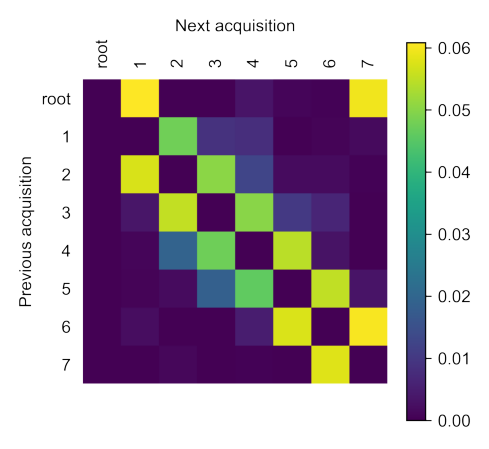

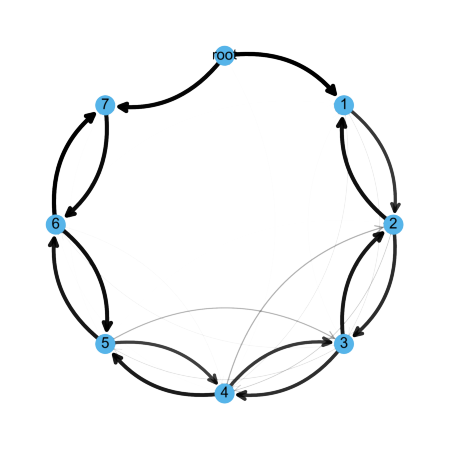

In [16]:
ShowImage("forwards-feature_graph_zero-one_joint_circular_adjacency.png")
ShowImage("forwards-feature_graph_zero-one_joint_circular_graph.png")

## Make and view Ordering Histograms

In [17]:
%%capture
pyscript = "../src/python/plot_ordering_histogram.py"
!{pyscript}\
    -f "forwards_list-pord-zero-one.csv"\
    -transition_data "transitions.txt"\
    -labels "labels.csv"\
    -fontsize 6\
    -xevery 1\
    -aspect 0.9\
    -verbose "no"\
    -outfile "forwards-ws1"\
    -out_type "png"

!{pyscript}\
    -f "forwards_list-pord-zero-one.csv"\
    -f2 "forwards_list-pord-match-data.csv"\
    -transition_data "transitions.txt"\
    -labels "labels.csv"\
    -fontsize 6\
    -xevery 1\
    -verbose "no"\
    -outfile "forwards-ws1-ws2"\
    -out_type "png"

__Inferred dynamics represented as the posterior probability that a feature (horizontal axis) is acquired at a given step (vertical axis).__ WS1 (walks from "zero" to "one") are shown top and WS2 (walks corresponding to transitions in the data) are shown bottom. Bimodality in ordering posteriors reflect the presence of distinct progressions that exist in the underlying dynamics. In this case, the "left-right" path competing with the "right-left".

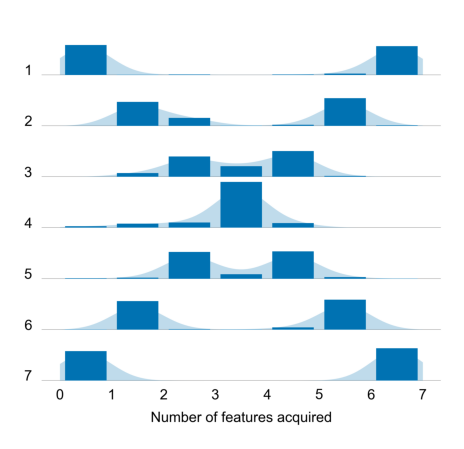

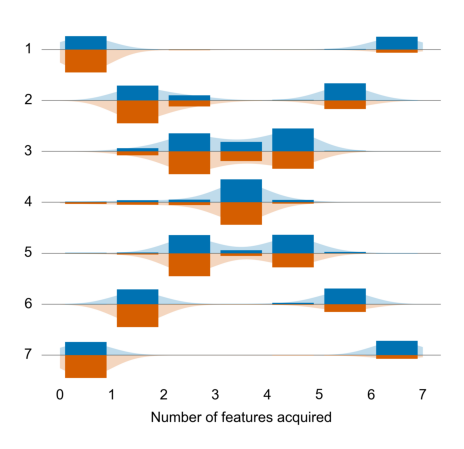

In [18]:
ShowImage("forwards-ws1.png")
ShowImage("forwards-ws1-ws2.png")

## Perform regularisation and plot results for second order model

In [19]:
regularisation_exe = "../bin/RUN_INFORMATION_CRITERION"
!{regularisation_exe} -h


----------------------------------------------------------------------------------------------------

HyperTraPS Discrete Time - regularisation and model selection

----------------------------------------------------------------------------------------------------

Description:
    Program for the purpose of perfoming model selection
    on the basis of:
      - A zero order model has been run
      - A first order model has been run

    Program looks up the max likelihood (in 100 steps) across MC run.

    Loads matrix in each case.

    Strips away elements one by one calculating the BIC and AIC for each new parameterisation.

    Outputs the:
    Parameters,DPs,log_lik,AIC,BIC to a file for each model type

    Outputs the matrix that is optimal for each model type.


Usage options:
  -f <input data file = "transitions.txt">
  -L <model type = "forwards.txt">
  -t <number of threads  = hardware_concurrency - 1>
  -T <number of tests for greedy backward selection = 100>
  -G <numb

In [20]:
%%capture
!{regularisation_exe}\
     -f transitions.txt\
     -t 3\
     -r 20\
     -L forwards.txt\
     -T 10\
     -G 0\
     -I AIC

In [21]:
%%capture
pyscript="../src/python/plot_information_criterion.py"
!{pyscript}\
    -f "forwards_information-criterion-0.csv"\
    -fontsize 6\
    -smooth_so 0\
    -outfile "forwards-information-critertion"\
    -pdf "no"

__Model regularization.__ Parameters are greedily pruned from each inferred model to identify a reduced parameter set that minimizes the AIC. The turning points illustrating an optimally sparse parameterization are marked for each model.

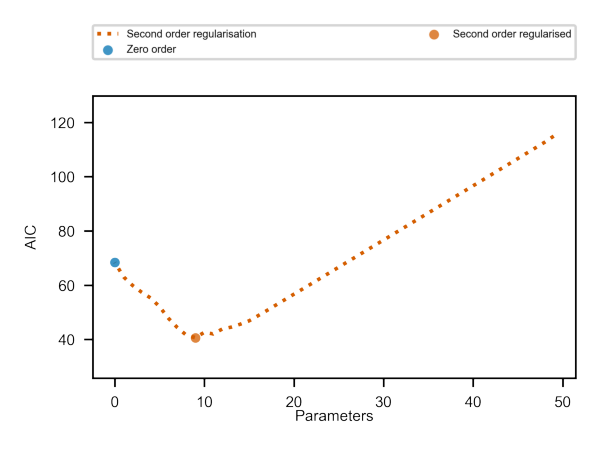

In [22]:
# Show regularisation path
ShowImage("forwards-information-critertion.png")

## Compare second-order model with first-order model

In [23]:
%%capture

# Set-up new workspace for first order model outputs
prefix = "../example_workspace_fo"
os.makedirs(prefix, exist_ok=True)
%cd {prefix}

# Run the conversion script
!python ../src/python/convert_data_to_transitions.py -data {dataset} -input_type {input_type}

# Command-line parameter choices
transitions = "transitions.txt"
model_type = "first-order"
trajectories = 20
posterior_samples = 1000
start_matrix = "zero"
prior_range = 20
proposal_kernel = "mcmc-apm"
sigma_for_kernel = 0.025
burn_in = 50000
iid_steps = 100
seed = 0
threads = 3
apm_proposal_kernel = 0
verbosity = 1

# Run MCMC
!{mcmc_exe}\
    -f {transitions}\
    -M {model_type}\
    -N {posterior_samples}\
    -r {trajectories}\
    -n {start_matrix}\
    -p {prior_range}\
    -k {proposal_kernel}\
    -s {sigma_for_kernel}\
    -b {burn_in}\
    -i {iid_steps}\
    -S {seed}\
    -t {threads}\
    -q {apm_proposal_kernel}

# Perform regularisation
!{regularisation_exe}\
     -f transitions.txt\
     -t 3\
     -r 20\
     -L forwards.txt\
     -T 10\
     -G 0\
     -I AIC

# Generate plot of MCMC trace
!python ../src/python/plot_mc_stats.py

### Examine MCMC trace

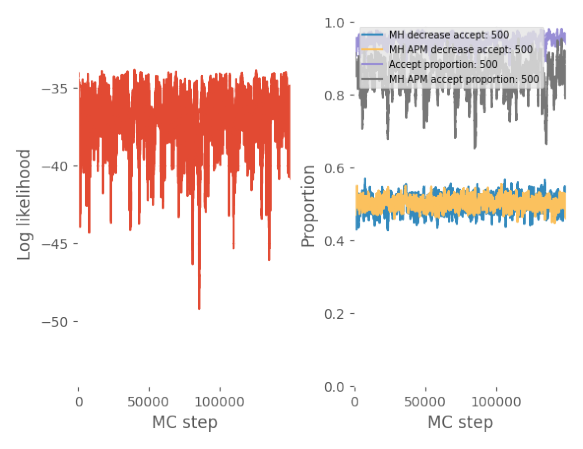

In [24]:
ShowImage("stats-0.png")

### Run regularisation plotting script

In [25]:
%%capture

pyscript="../src/python/plot_information_criterion.py"
!{pyscript}\
    -f "../example_workspace/forwards_information-criterion-0.csv"\
    -f2 "forwards_information-criterion-0.csv"\
    -fontsize 6\
    -smooth_so 0\
    -outfile "forwards-information-critertion"\
    -pdf "no"

### Show regularisation path for first- and second- order models together

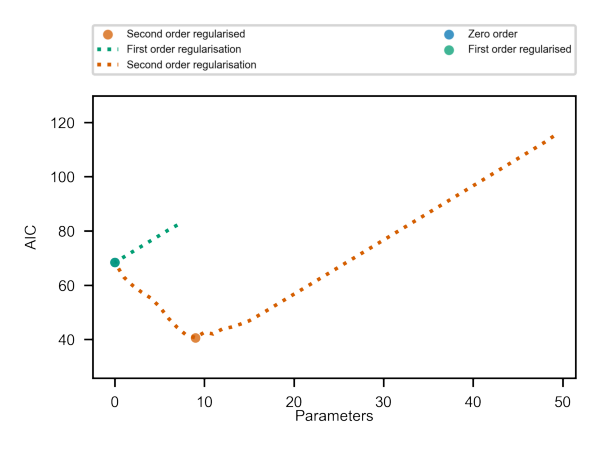

In [26]:
ShowImage("forwards-information-critertion.png")

__Conclusion.__ The regularisation procedure on both the first- and second- order models show that a lower
AIC is reached with the second-order model.